A neural network to model wildfires, using Keras.

This code originally ran on an AWS P3.8xlarge, which is some hefty iron. This code may not run on lesser machines.

In [1]:
import pymongo
from pyprind import ProgBar

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
local = pymongo.MongoClient()
local = local.local

firemind = local.get_collection('firemind')
firemind.estimated_document_count()

71039

In [3]:
import numpy as np
import keras

from keras import layers
from keras import models
from keras import optimizers
from keras.layers import *

def bytes_to_raster(buf, shape):
    br = np.frombuffer(buf, dtype=np.float32)
    r = br.reshape(shape)
    return r

Using TensorFlow backend.


In [6]:
import pickle

op = open('models/identsBI.pkl', 'rb')
idents = pickle.load(op)
op.close()

In [7]:
firemind.estimated_document_count()/9

7893.222222222223

In [8]:
#we use the first 36864 convolutions, because that fits in memory. 
#change k to a small number for ordinary machines.

k = 4096

val_split = k*7
tt_split = k*8
t_len = k*9

print(t_len)

36864


In [9]:
x = np.empty([t_len, 256*256])
y = np.empty([t_len, 256*256])
z = np.empty([t_len, 256, 256, 4])
w = np.empty([t_len, 24, 6])

progbar = ProgBar(t_len)

for i, ident in enumerate(idents[0:t_len]):
    cursor = firemind.find({'_id': ident})
    for a in cursor:
        topo = bytes_to_raster(a['topo'], a['t_shape'])
        atmo = bytes_to_raster(a['atmo'], a['a_shape'])
        q = np.swapaxes(topo[2:,:,:], 0, 2)
        a = np.mean(np.mean(atmo, axis=2), axis=2)[:,-24:] #mean spatial dimensions from the wind vector, #set to 24 hr
        a = np.swapaxes(a, 0, 1)                
        x[i] = topo[1,:,:].ravel()
        y[i] = topo[0,:,:].ravel()
        try:
            w[i] = a
        except:
            pass
        z[i] = q 
        progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:16


In [10]:
x_train = x[0:val_split]
y_train = y[0:val_split]
z_train = z[0:val_split]
w_train = w[0:val_split]

x_val = x[val_split:tt_split]
y_val = y[val_split:tt_split]
z_val = z[val_split:tt_split]
w_val = w[val_split:tt_split]

x_test = x[tt_split:]
y_test = y[tt_split:]
z_test = z[tt_split:]
w_test = w[tt_split:]

In [11]:
x_train.shape

(28672, 65536)

Keras defaults to using accuracy, however our classes of on-fire (1) and not-on-fire(0), are not balanced across the convolutions, and are not equal in importance.  I chose the F1 score as a reasonable proxy for getting the right results.

In [13]:
import keras.backend as K

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Each convolution is a 256 * 256 array with a target (on-fire/ not-on-fire), topographical and fuel load data, and associate weather for the past 124 hours.  

The neural network architecture consists of three networks.  A CNN (n) extracts high-level topographic features, a LSTM (q) sums up weather data, and this is combined with the targets to feed through a multilayer perceptron with dropout (m).

In [15]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.models import Model

perim_input = Input(shape=(65536,), dtype='float32', name='perim_input')
wind_input = Input(shape=(24,6), name='wind_input')
topo_input = Input(shape=(256, 256, 4), name='topo_input')

n = Conv2D(32, (7,7), activation = 'relu', padding='same')(topo_input)
n = MaxPooling2D((4,4))(n)
n = Conv2D(64, (3,3), padding='same')(n)
n = MaxPooling2D((2,2))(n)
n = Flatten()(n)
n = Dropout(0.5)(n)
n = Dense(32*32)(n)

q = LSTM(24)(wind_input)
q = Dense(8, activation='relu')(q)
m = keras.layers.concatenate([perim_input, q, n])
m = Dense(512, activation='relu')(m)
m = Dropout(.33)(m)
m = Dense(512, activation='relu')(m)
m = Dropout(.33)(m)
main_output = Dense(65536, activation='sigmoid', name='main_output')(m)

model = Model(inputs=[perim_input, wind_input, topo_input], outputs=[main_output])


model.compile(loss='categorical_crossentropy',
             optimizer='Adadelta',
             metrics = [f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
topo_input (InputLayer)         (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 6304        topo_input[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [16]:
history = model.fit([x_train, w_train, z_train], y_train, 
                    batch_size=512, epochs=8,
                   validation_data=([x_val, w_val, z_val], y_val))

Train on 28672 samples, validate on 4096 samples
Epoch 1/8
28672/28672 [==============================] - 904s 32ms/step - loss: 344624.1055 - f1: 0.7422 - val_loss: 343717.0000 - val_f1: 0.8524
Epoch 2/8
28672/28672 [==============================] - 897s 31ms/step - loss: 338859.0915 - f1: 0.8410 - val_loss: 342825.5391 - val_f1: 0.8716
Epoch 3/8
28672/28672 [==============================] - 898s 31ms/step - loss: 337842.8622 - f1: 0.8586 - val_loss: 342338.3438 - val_f1: 0.8811
Epoch 4/8
28672/28672 [==============================] - 897s 31ms/step - loss: 337281.4576 - f1: 0.8680 - val_loss: 341922.4609 - val_f1: 0.8857
Epoch 5/8
28672/28672 [==============================] - 897s 31ms/step - loss: 336691.5859 - f1: 0.8751 - val_loss: 341665.9609 - val_f1: 0.8898
Epoch 6/8
28672/28672 [==============================] - 897s 31ms/step - loss: 336166.0965 - f1: 0.8814 - val_loss: 341681.9648 - val_f1: 0.8897
Epoch 7/8
28672/28672 [==============================] - 896s 31ms/step - l

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_f1', 'loss', 'f1'])

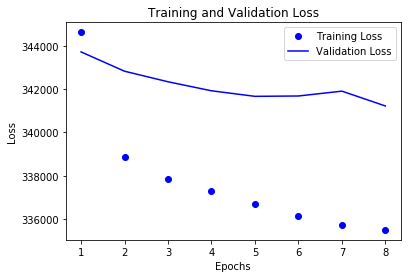

In [18]:
loss_values =  history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

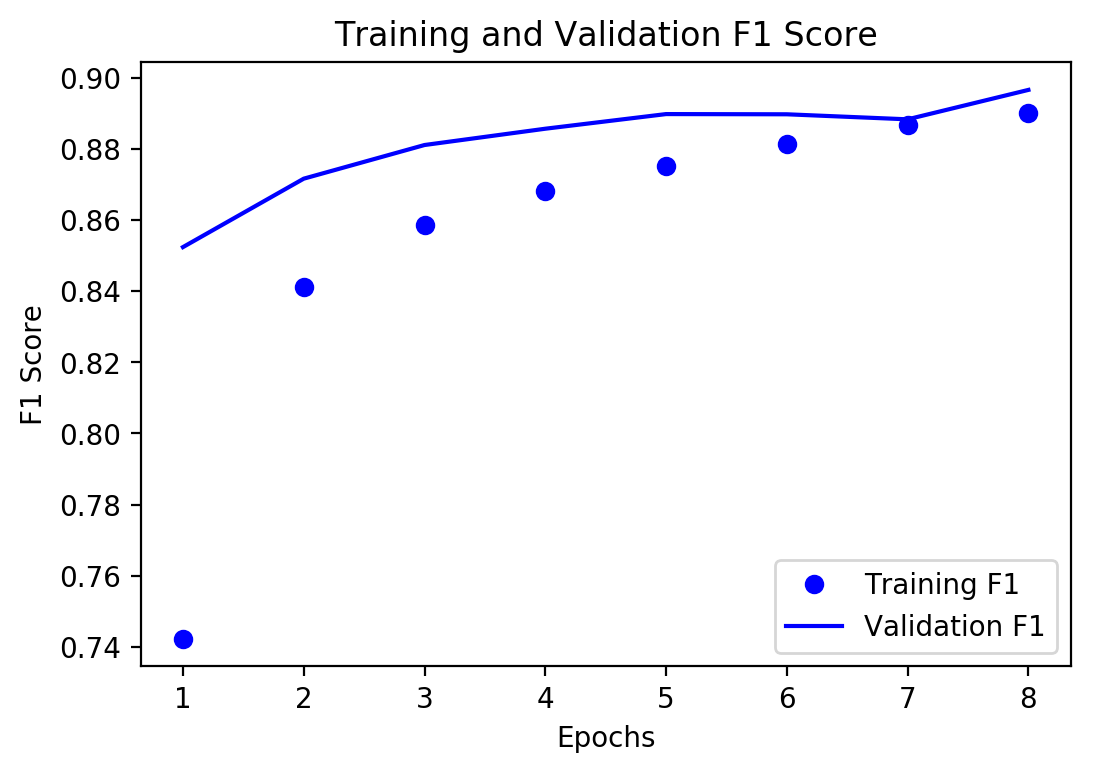

In [19]:
acc_values =  history_dict['f1']
val_acc_values = history_dict['val_f1']

fig, ax = plt.subplots(figsize=(6,4), dpi=200)

epochs = range(1, len(loss_values)+1)
ax.plot(epochs, acc_values, 'bo', label='Training F1')
ax.plot(epochs, val_acc_values, 'b', label='Validation F1')
ax.set_title('Training and Validation F1 Score')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 Score')
ax.legend()

In [20]:
#model.save('models/simple_perceptron6')
model.save('models/complex_perceptron8')

In [21]:
op = open('models/CM8 history.pkl', 'wb')
idents = pickle.dump(history.history, op)
op.close()

In [22]:
preds = model.predict([x_test, w_test, z_test])

In [32]:
z_test[180]
np.swapaxes(z_test[180], 0, 2)

(4, 256, 256)

Example charts.  Change K to view different perimeters.

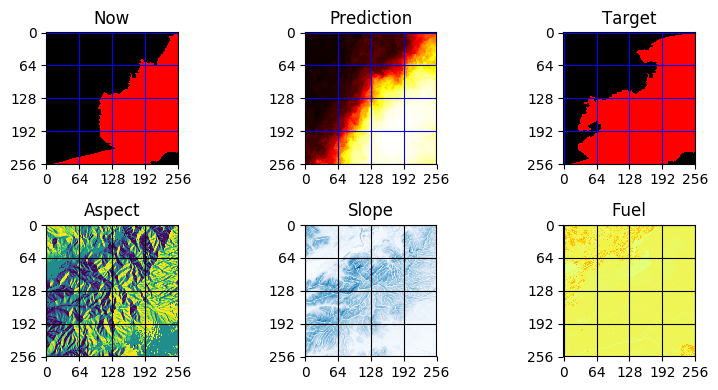

In [27]:
k= 3740

import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['black', 'red'])
cmap2 = mpl.colors.ListedColormap(['black', 'orange'])

fig, ax  = plt.subplots(2,3, figsize=(8,4), dpi=100,
                       subplot_kw={'xticks': np.arange(0, 257, step=64), 
                                   'yticks': np.arange(0, 257, step=64)})

ax[0,0].imshow(x_test[k].reshape([256, 256]), cmap=cmap)
ax[0,0].set_title('Now')
ax[0,0].grid(color='blue')

ax[0,1].imshow(preds[k].reshape([256, 256]), cmap='hot')
ax[0,1].set_title('Prediction')
ax[0,1].grid(color='blue')

ax[0,2].imshow(y_test[k].reshape([256, 256]), cmap=cmap)
ax[0,2].set_title('Target')
ax[0,2].grid(color='blue')

ax[1,0].imshow(np.swapaxes(z_test[k], 0, 2)[0])
ax[1,0].grid(color='black')
ax[1,0].set_title('Aspect')

ax[1,1].imshow(np.swapaxes(z_test[k], 0, 2)[2], cmap='Blues')
ax[1,1].grid(color='black')
ax[1,1].set_title('Slope')

ax[1,2].imshow(np.swapaxes(z_test[k], 0, 2)[3], cmap='Wistia')
ax[1,2].grid(color='black')
ax[1,2].set_title('Fuel')

fig.tight_layout()

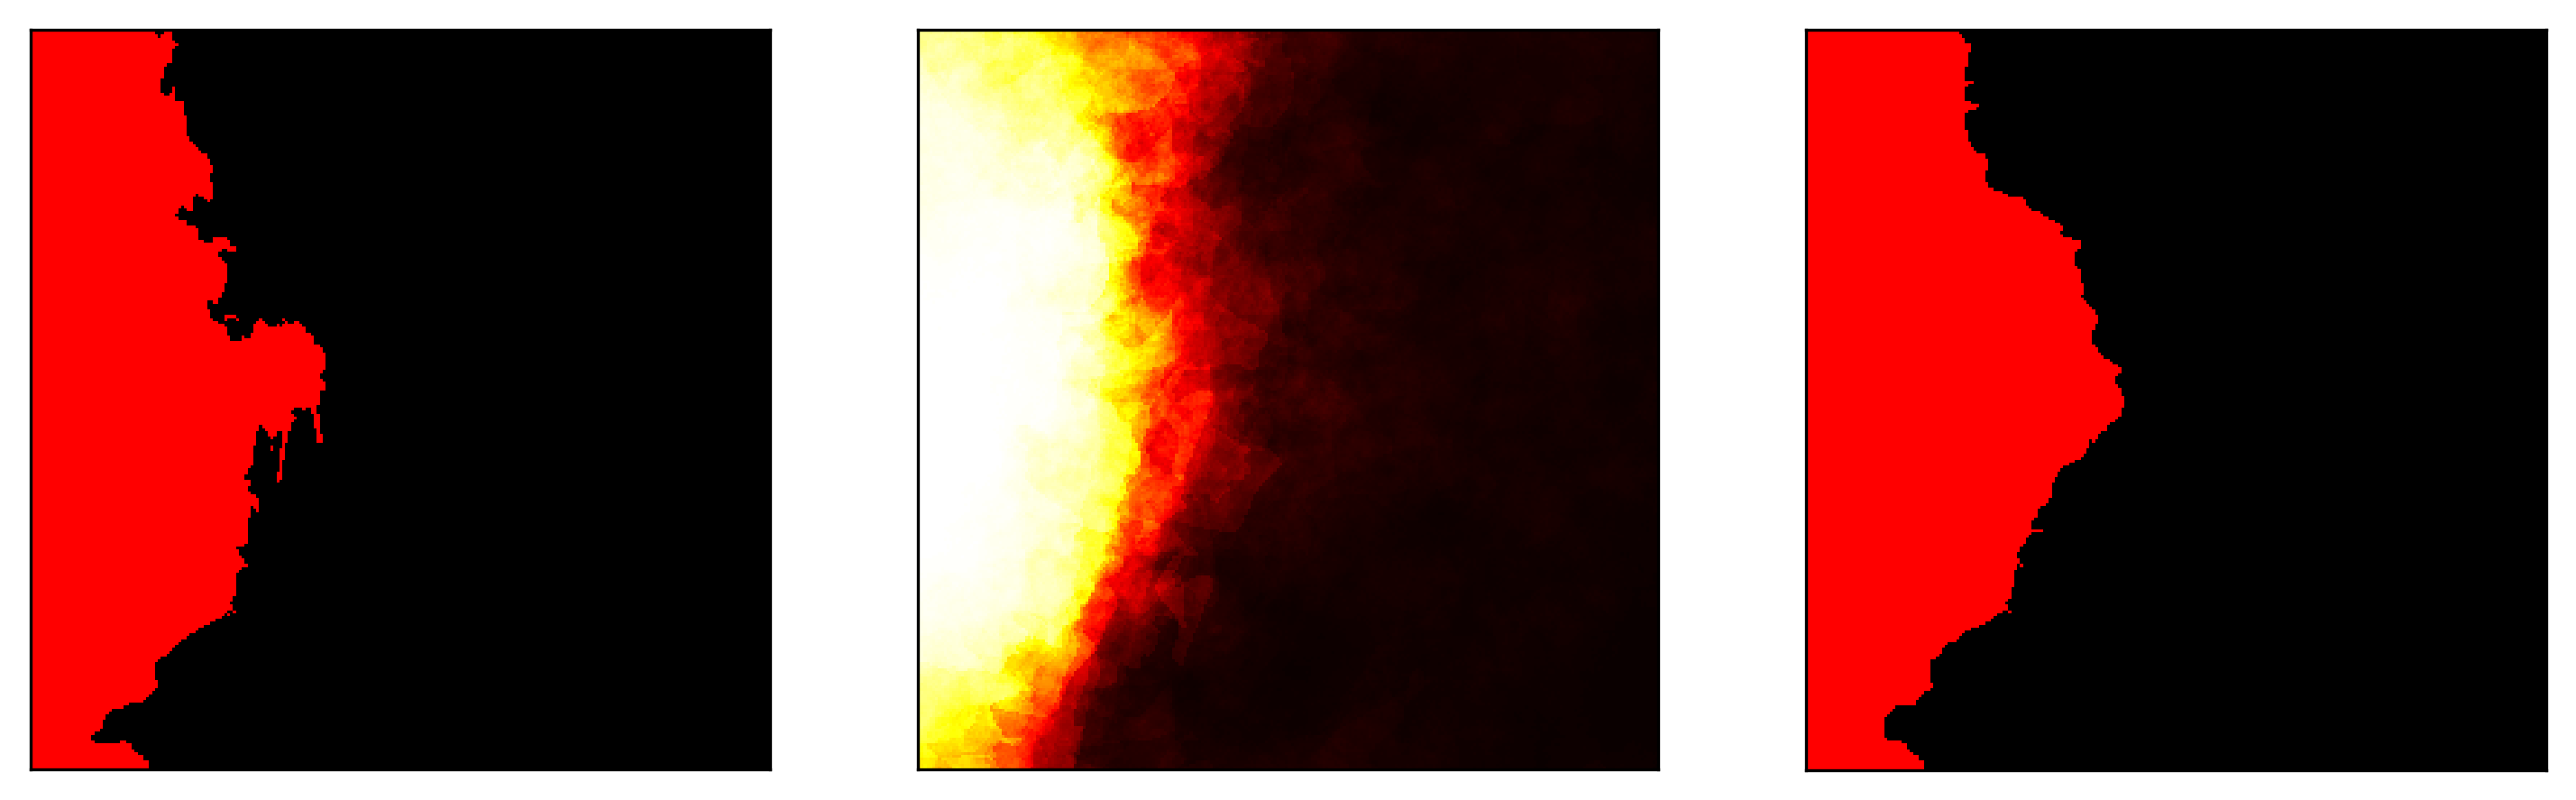

In [45]:
fig, ax  = plt.subplots(1,3, figsize=(12,6), dpi=300,
                       subplot_kw={'xticks': [], 
                                   'yticks': []})

ax[0].imshow(x_test[k].reshape([256, 256]), cmap=cmap)
# ax[0].set_title('Now')
# ax[0].grid(color='blue')

ax[1].imshow(preds[k].reshape([256, 256]), cmap='hot')
# ax[1].set_title('Prediction')
# ax[1].grid(color='blue')

ax[2].imshow(y_test[k].reshape([256, 256]), cmap=cmap)
# ax[2].set_title('Target')
# ax[2].grid(color='blue')

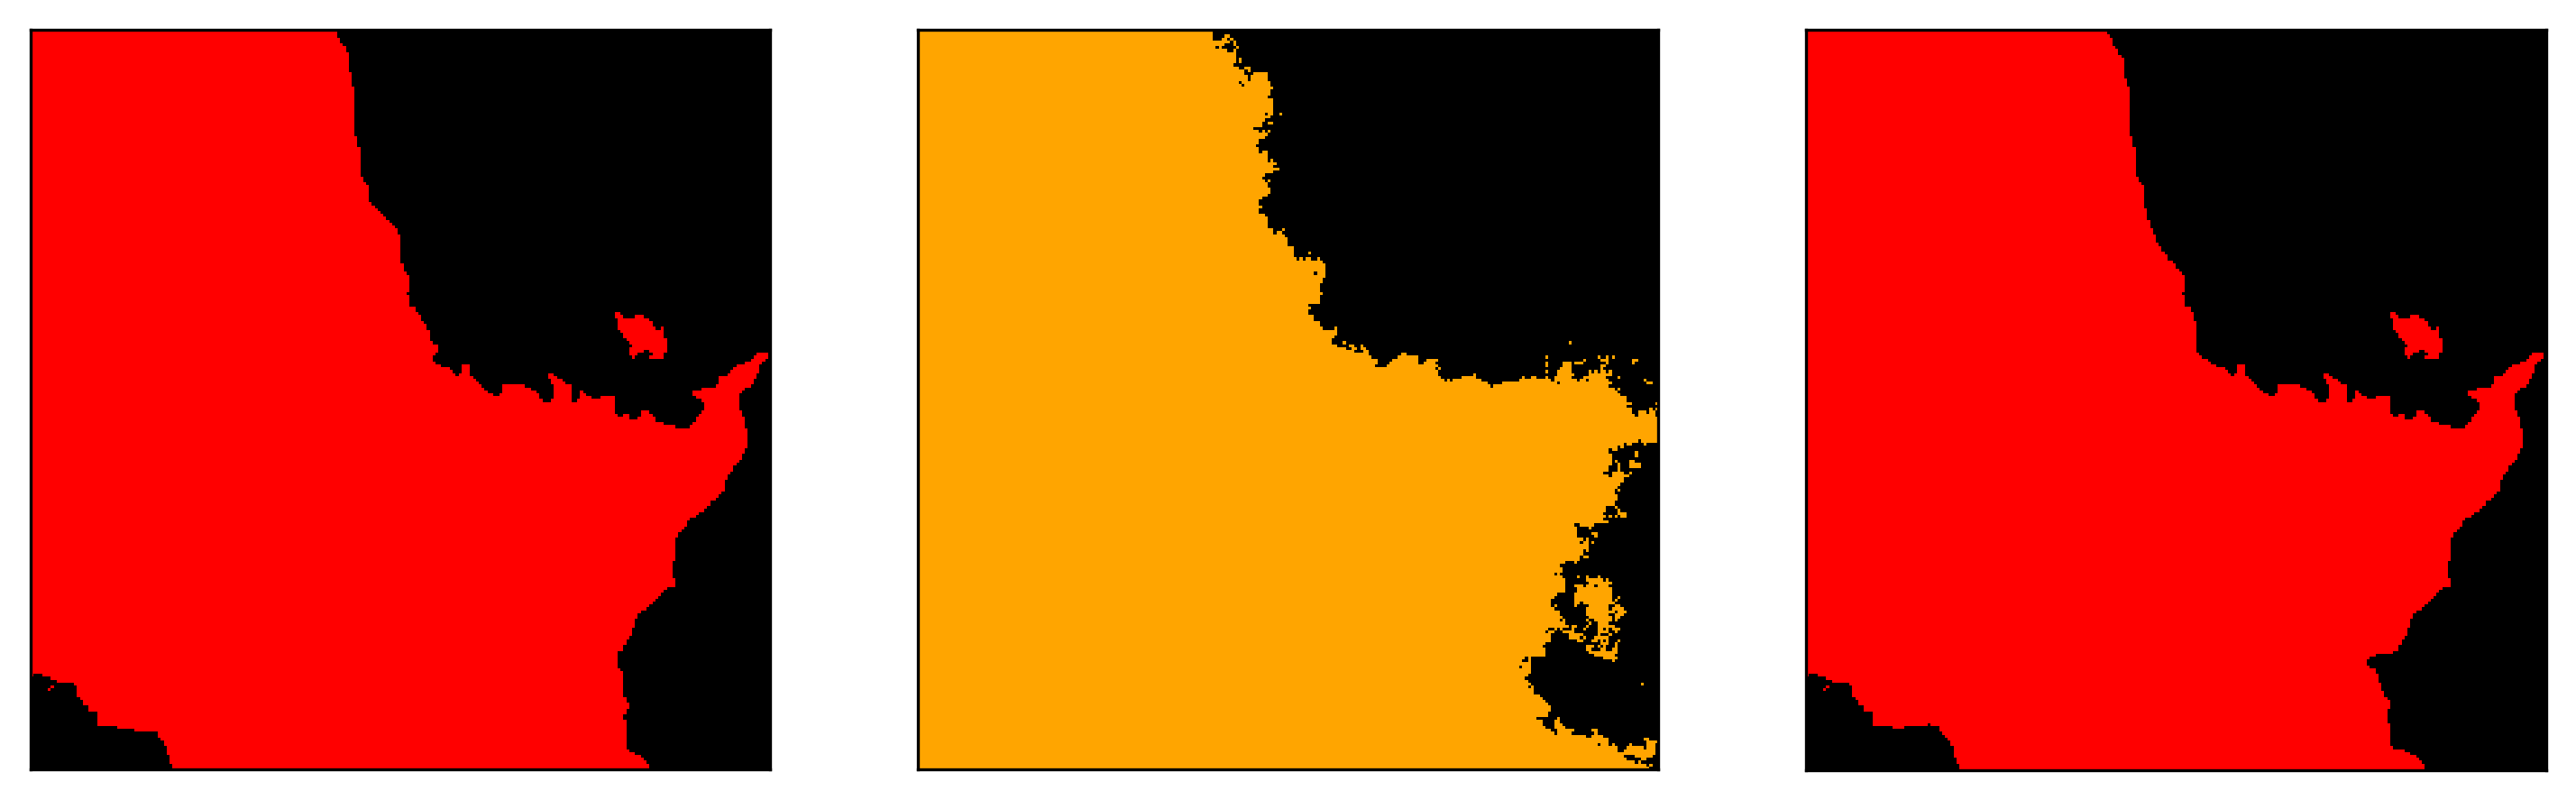

In [33]:
fig, ax  = plt.subplots(1,3, figsize=(12,6), dpi=300,
                       subplot_kw={'xticks': [], 
                                   'yticks': []})

ax[0].imshow(x_test[k].reshape([256, 256]), cmap=cmap)
# ax[0].set_title('Now')
# ax[0].grid(color='blue')

ax[1].imshow(preds[k].reshape([256, 256])>.3, cmap=cmap2)
# ax[1].set_title('Prediction')
# ax[1].grid(color='blue')

ax[2].imshow(y_test[k].reshape([256, 256]), cmap=cmap)
# ax[2].set_title('Target')
# ax[2].grid(color='blue')

In [ ]:
def generator(features, labels, batch_size):
    batch_features = np.zeros((batch_size, 256, 256, 3))
    batch_labels = np.zeros((batch_size,256*256))
    while True:
        for i in range(batch_size):
            index= random.choice(len(features),1)
            
            topo = bytes_to_raster(a['topo'], a['t_shape'])
            atmo = bytes_to_raster(a['atmo'], a['a_shape'])
            q = np.swapaxes(topo[1:,:,:], 0, 2)
            y.append(topo[0,:,:].ravel())
            x.append(topo[1,:,:].ravel())
            wind_vec = np.zeros(atmo.shape[0])
            for i in range(len(wind_vec)):
                wind_vec[i] = np.sum(atmo[i])/atmo.shape[-2:-1]

    z.append(wind_vec)
            
            batch_features[i] = some_processing(features[index])
            batch_labels[i] = labels[index]
    yield batch_features, batch_labels

In [29]:
def npf1(y_true, y_pred):
    """y_true and y_pred are binary arrays of the same shape"""
    epsilon = 1e-9 
    TP =  np.sum(np.logical_and(y_true,y_pred))
    precision =  TP/np.sum(y_pred+epsilon)
    recall = TP/np.sum(y_true+epsilon)
    f1 = 2*precision*recall/(precision+recall+epsilon)
    return f1

In [125]:
def myacc(y_true, y_pred):
    acc = np.sum((y_true-y_pred) == 0)/(256*256)
    return acc

In [127]:
y_pred =  preds[7] > 0.3

myacc(y_test[7], y_pred)

0.8260040283203125

In [35]:
f1scores = []
accs = []

progbar = ProgBar(len(x_test))

for j in range(len(x_test)):
    try:
        f1score = npf1(y_test[j], preds[j] > .5)
        acc = np.sum(y_test[j] == (preds[j] > .3))/(256*256)
        f1scores.append(f1score)
        accs.append(acc)
        progbar.update()
    except:
        pass

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [36]:
a= np.mean(f1scores)
b=np.std(f1scores)
print(a, b)

0.8446072865786531 0.08555294953162991


In [31]:
a= np.mean(accs)
b=np.std(accs)
print(a, b)

0.8252908438444138 0.0933100365583261


In [37]:
import seaborn as sns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[]

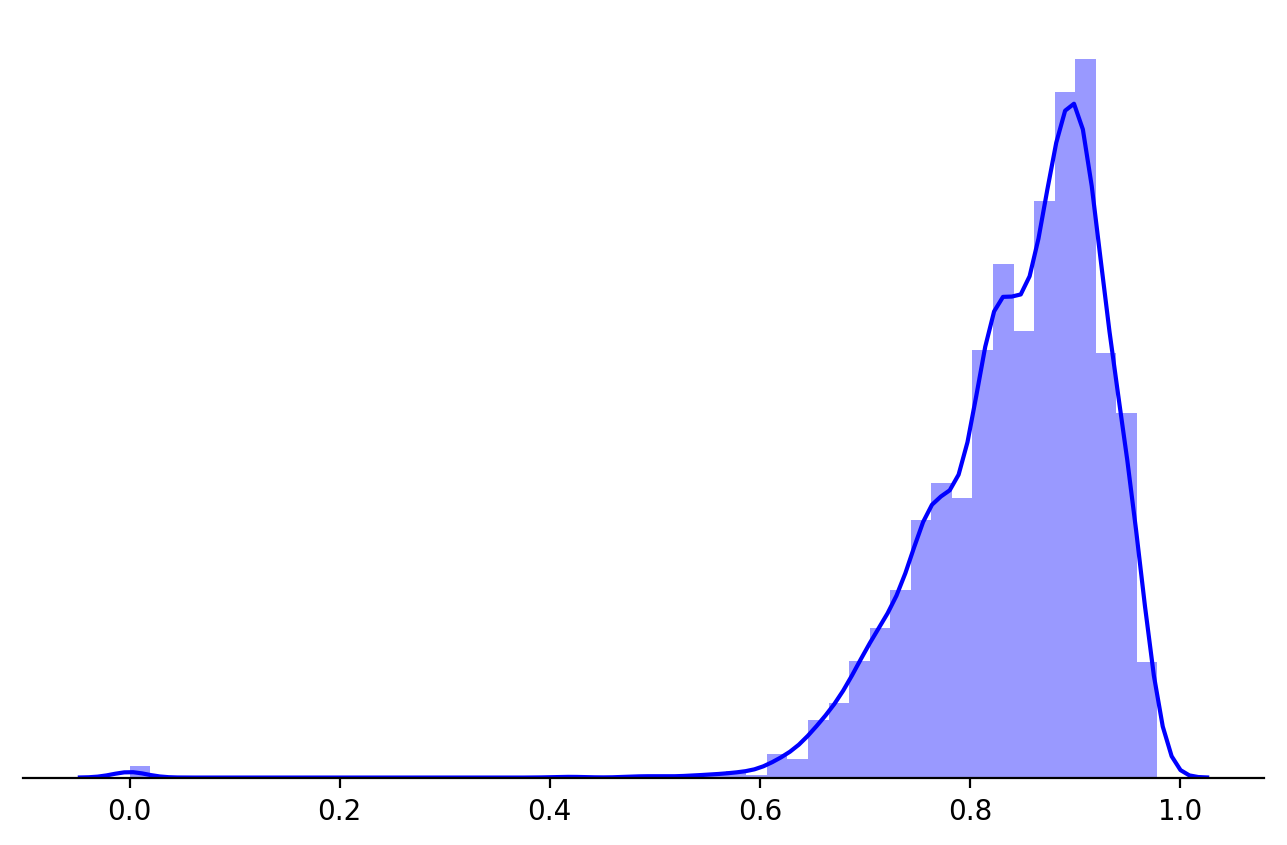

In [60]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200, frameon=False)

sns.distplot(f1scores,color='blue')
sns.despine(left=True)
#ax.set_frame_on(False)
ax.set_yticks([])